# ATV 04 - CNN

In [37]:
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
from scikeras.wrappers import KerasClassifier
import keras_tuner

from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

import numpy as np
import random

RANDOM_STATE = 42

random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

In [38]:
def download_mnist_and_preprocess():
    # download and holdout
    (X_all, y_all), (X_test, y_test) = mnist.load_data()

    # reshape for a single color channel
    X_all = X_all.reshape((X_all.shape[0], 28, 28, 1))
    X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))
    
    X_train = X_all[10000:]
    X_valid = X_all[:10000]

    y_train = y_all[10000:]
    y_valid = y_all[:10000]

    # normalize pixels to [0, 1] range
    X_train = X_train.astype("float32") / 255

    X_test = X_test.astype("float32") / 255

    X_valid = X_valid.astype("float32") / 255

    # one hot encode output
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    y_valid = to_categorical(y_valid)

    return [(X_train, y_train), (X_valid, y_valid), (X_test, y_test)]



## Modelo Baseline

In [39]:
# define cnn model
def define_baseline_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(learning_rate=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

	return model

In [40]:
baseline_model = define_baseline_model()
baseline_model.summary()

/usr/local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 100)            │       540,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 542,230 (2.07 MB)

 Trainable params: 542,230 (2.07 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
[(X_train, y_train), (X_valid, y_valid), (X_test, y_test)] = download_mnist_and_preprocess()

In [42]:
train_res = baseline_model.fit(
    X_train,
    y_train,
    epochs=15,
    batch_size=128,
    validation_data=(X_valid, y_valid)
)

Epoch 1/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - accuracy: 0.8420 - loss: 0.5261 - val_accuracy: 0.9562 - val_loss: 0.1552
Epoch 2/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.9605 - loss: 0.1381 - val_accuracy: 0.9683 - val_loss: 0.1089
Epoch 3/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.9744 - loss: 0.0907 - val_accuracy: 0.9750 - val_loss: 0.0844
Epoch 4/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.9815 - loss: 0.0671 - val_accuracy: 0.9786 - val_loss: 0.0756
Epoch 5/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.9862 - loss: 0.0524 - val_accuracy: 0.9805 - val_loss: 0.0694
Epoch 6/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.9886 - loss: 0.0426 - val_accuracy: 0.9815 - val_loss: 0.0649
Epoch 7/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.9904 - loss: 0.0354 - val_accuracy: 0.9824 - val_loss: 0.0625
Epoch 8/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.9920 - loss: 0.0299 - 

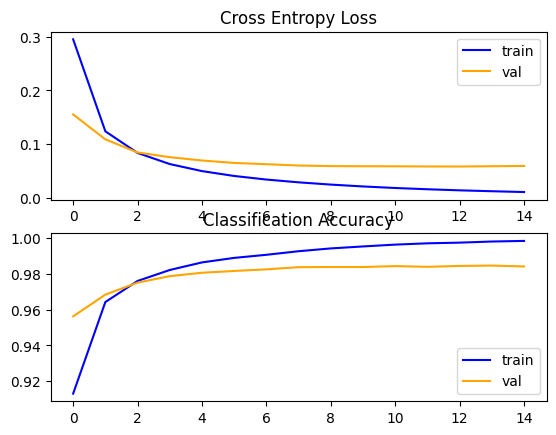

In [43]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# plot loss
		plt.subplot(2, 1, 1)
		plt.title('Cross Entropy Loss')
		plt.plot(histories[i].history['loss'], color='blue', label='train')
		plt.plot(histories[i].history['val_loss'], color='orange', label='val')
		plt.legend(loc="upper right")
		# plot accuracy
		plt.subplot(2, 1, 2)
		plt.title('Classification Accuracy')
		plt.plot(histories[i].history['accuracy'], color='blue', label='train')
		plt.plot(histories[i].history['val_accuracy'], color='orange', label='val')
		plt.legend(loc="lower right")
	plt.show()
	
summarize_diagnostics([train_res])

### Baseline Acc

In [44]:
pred_probas = baseline_model.predict(X_test)
pred_labels = [np.argmax(i) for i in pred_probas]

real_labels = tf.argmax(y_test, axis=1)

acc = accuracy_score(pred_labels, real_labels)
print(f"accuracy score: {acc}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
accuracy score: 0.984


## Modelo mais profundo -> + 2 conv + 1 max pooling

In [45]:
# define cnn model
def define_more_conv_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(learning_rate=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

	return model

In [46]:
more_conv_model = define_more_conv_model()
more_conv_model.summary()

/usr/local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 9, 9, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 100)            │       102,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,254 (622.09 KB)

 Trainable params: 159,254 (622.09 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
move_conv_train_res = more_conv_model.fit(
    X_train,
    y_train,
    epochs=15,
    batch_size=128,
    validation_data=(X_valid, y_valid)
)

Epoch 1/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 103ms/step - accuracy: 0.8411 - loss: 0.5290 - val_accuracy: 0.9773 - val_loss: 0.0787
Epoch 2/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 101ms/step - accuracy: 0.9776 - loss: 0.0729 - val_accuracy: 0.9830 - val_loss: 0.0600
Epoch 3/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 39s 99ms/step - accuracy: 0.9838 - loss: 0.0491 - val_accuracy: 0.9840 - val_loss: 0.0568
Epoch 4/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 34s 86ms/step - accuracy: 0.9882 - loss: 0.0375 - val_accuracy: 0.9857 - val_loss: 0.0506
Epoch 5/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 34s 87ms/step - accuracy: 0.9903 - loss: 0.0308 - val_accuracy: 0.9864 - val_loss: 0.0490
Epoch 6/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 33s 85ms/step - accuracy: 0.9926 - loss: 0.0244 - val_accuracy: 0.9870 - val_loss: 0.0469
Epoch 7/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 33s 83ms/step - accuracy: 0.9935 - loss: 0.0206 - val_accuracy: 0.9887 - val_loss: 0.0426
Epoch 8/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 32s 82ms/step - accuracy: 0.9945 - loss: 0.0172 

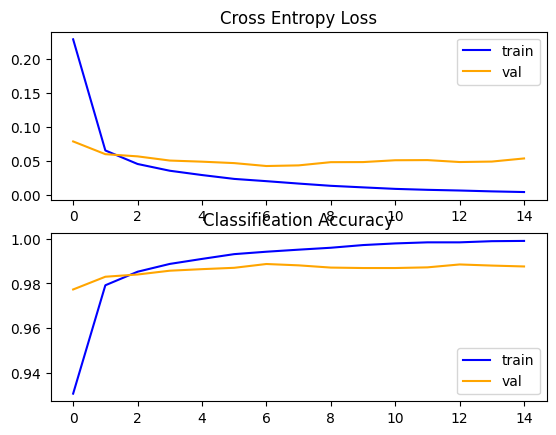

In [48]:
summarize_diagnostics([move_conv_train_res])

### Experimento 1 Acc

In [49]:
pred_probas2 = more_conv_model.predict(X_test)
pred_labels2 = [np.argmax(i) for i in pred_probas2]

real_labels2 = tf.argmax(y_test, axis=1)

acc2 = accuracy_score(pred_labels2, real_labels2)
print(f"accuracy score: {acc2}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
accuracy score: 0.9893


## Modelo mais profundo 2 -> 200 neurônios na camada escondida densa

In [50]:
# define cnn model
def define_more_conv_model2():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(200, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(learning_rate=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

	return model

In [51]:
more_conv_model2 = define_more_conv_model2()
more_conv_model2.summary()

/usr/local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 200)            │     1,081,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │         2,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,084,130 (4.14 MB)

 Trainable params: 1,084,130 (4.14 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
more_conv_train_res2 = more_conv_model2.fit(
    X_train,
    y_train,
    epochs=15,
    batch_size=128,
    validation_data=(X_valid, y_valid)
)

Epoch 1/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.8535 - loss: 0.4788 - val_accuracy: 0.9598 - val_loss: 0.1356
Epoch 2/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.9669 - loss: 0.1147 - val_accuracy: 0.9733 - val_loss: 0.0915
Epoch 3/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.9780 - loss: 0.0772 - val_accuracy: 0.9785 - val_loss: 0.0725
Epoch 4/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.9831 - loss: 0.0581 - val_accuracy: 0.9810 - val_loss: 0.0659
Epoch 5/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.9873 - loss: 0.0457 - val_accuracy: 0.9816 - val_loss: 0.0633
Epoch 6/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.9902 - loss: 0.0374 - val_accuracy: 0.9819 - val_loss: 0.0625
Epoch 7/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.9922 - loss: 0.0310 - val_accuracy: 0.9824 - val_loss: 0.0611
Epoch 8/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.9944 - loss: 0.0259 - 

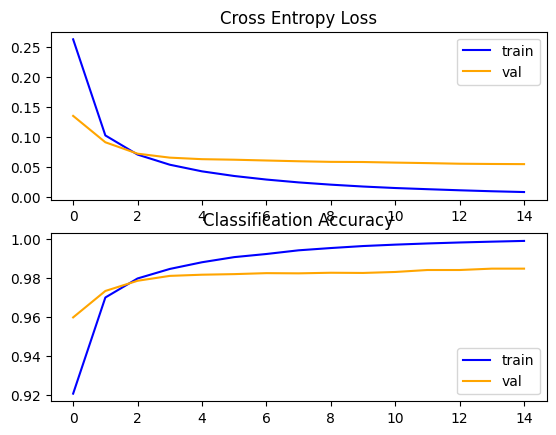

In [53]:
summarize_diagnostics([more_conv_train_res2])

### Experimento 2 Acc

In [54]:
pred_probas3 = more_conv_model2.predict(X_test)
pred_labels3 = [np.argmax(i) for i in pred_probas3]

real_labels3 = tf.argmax(y_test, axis=1)

acc2 = accuracy_score(pred_labels3, real_labels3)
print(f"accuracy score: {acc2}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
accuracy score: 0.9855


## Experimento 3 -> + 2 conv + 2 max pooling + 200 neuronios na camada escondida densa

In [55]:
# define cnn model
def define_more_conv_and_dense_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(200, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(learning_rate=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

	return model

In [56]:
final_model = define_more_conv_and_dense_model()
final_model.summary()

/usr/local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 200)            │        13,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │         2,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,754 (276.38 KB)

 Trainable params: 70,754 (276.38 KB)

 Non-trainable params: 0 (0.00 B)

In [57]:
final_model_train_res = final_model.fit(
    X_train,
    y_train,
    epochs=15,
    batch_size=128,
    validation_data=(X_valid, y_valid)
)

Epoch 1/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.7898 - loss: 0.6603 - val_accuracy: 0.9587 - val_loss: 0.1399
Epoch 2/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.9650 - loss: 0.1143 - val_accuracy: 0.9696 - val_loss: 0.1042
Epoch 3/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.9764 - loss: 0.0765 - val_accuracy: 0.9723 - val_loss: 0.0936
Epoch 4/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - accuracy: 0.9816 - loss: 0.0601 - val_accuracy: 0.9763 - val_loss: 0.0797
Epoch 5/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - accuracy: 0.9846 - loss: 0.0493 - val_accuracy: 0.9787 - val_loss: 0.0710
Epoch 6/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - accuracy: 0.9869 - loss: 0.0423 - val_accuracy: 0.9810 - val_loss: 0.0678
Epoch 7/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 62ms/step - accuracy: 0.9885 - loss: 0.0368 - val_accuracy: 0.9797 - val_loss: 0.0696
Epoch 8/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 60ms/step - accuracy: 0.9896 - loss: 0.0329 - 

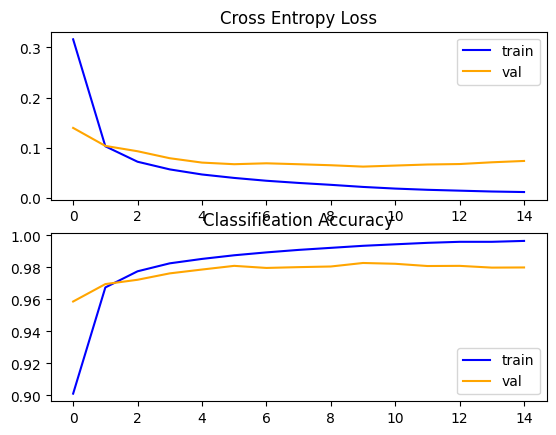

In [58]:
summarize_diagnostics([final_model_train_res])

In [59]:
pred_probas4 = final_model.predict(X_test)
pred_labels4 = [np.argmax(i) for i in pred_probas4]

real_labels4 = tf.argmax(y_test, axis=1)

acc4 = accuracy_score(pred_labels4, real_labels4)
print(f"accuracy score: {acc4}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
accuracy score: 0.9809


# Discussão

Adicionar duas camadas convolucionais de 64 filtros + uma camada max pooling 2x2 melhorou a acurácia do modelo para essa base de teste melhor do que qualquer outro experimento, levando da acurácia baseline de 0.984 para 0.9893. Aumentar somente o número de neurônios na camada densa de 100 para 200 também aumentou a acurácia para 0.9855, menos do que o primeiro experimento sozinho. Por fim, um terceiro experimento juntando os dois anteriores rendeu uma acurácia de 0.9809, sendo a segunda melhor, atrás do primeiro experimento.

De modo a encontrar os hiperparâmetros ótimos, caberia realizar um experimento de busca em um espaço de hiperparâmetros com validação cruzada em outras seções da base de dados, otimizando a quantidade de camadas convolucionais, max pooling e contagem de neurônios na camada densa.